Dưới vai trò Giáo sư Dược học, tôi sẽ hướng dẫn bạn triển khai chủ đề **T7: Thiết kế thuốc dựa trên ligand từ ChEMBL** bằng cách phân tích song ngữ, kèm theo các đoạn mã SQL và Python cụ thể. Nội dung này phù hợp với mô hình AIMLOps và tập trung vào xử lý 100 dòng dữ liệu để đảm bảo hiệu suất tốt.

---

## 🧠 T7. Ligand-Based Drug Design from ChEMBL

**T7. Thiết kế thuốc dựa trên ligand từ Cơ sở dữ liệu ChEMBL**

---

### 1. 🔬 Phân tích nội dung chủ đề | Topic Analysis

**EN:** Ligand-based drug design (LBDD) uses known bioactive molecules (ligands) to develop new compounds by analyzing their chemical structure and activity. With ChEMBL and RDKit, we can retrieve ligand data, calculate molecular descriptors, and apply similarity analysis or QSAR modeling.

**VI:** Thiết kế thuốc dựa trên ligand (Ligand-Based Drug Design - LBDD) là phương pháp sử dụng các phân tử có hoạt tính sinh học đã biết để tạo ra hợp chất mới bằng cách phân tích cấu trúc và hoạt tính của chúng. Với ChEMBL và RDKit, ta có thể trích xuất dữ liệu ligand, tính toán descriptor phân tử và áp dụng phân tích độ tương đồng hoặc xây dựng mô hình QSAR.

---

### 2. 🧪 Mô hình phân tích | Analysis Model

**EN:**

* Step 1: Query ligands active against a specific target (e.g., EGFR)
* Step 2: Clean IC50/EC50 values and extract canonical SMILES
* Step 3: Use RDKit to compute descriptors (e.g., MolWt, TPSA, LogP)
* Step 4: Perform similarity clustering or QSAR model

**VI:**

* Bước 1: Truy vấn các ligand có hoạt tính với một mục tiêu cụ thể (ví dụ EGFR)
* Bước 2: Làm sạch giá trị IC50/EC50, lấy SMILES chuẩn
* Bước 3: Sử dụng RDKit để tính toán các thông số descriptor (MolWt, TPSA, LogP…)
* Bước 4: Thực hiện phân nhóm theo độ tương đồng hoặc xây dựng mô hình QSAR

---

### 3. 🧾 SQL Code Example 1: Extract 100 Ligands with IC50 Against EGFR

```sql
-- File: T7_1_get_egfr_ligands.sql
SELECT mol.molregno, mol.canonical_smiles, act.standard_value AS ic50_nm
FROM activities AS act
JOIN molecule_dictionary AS mol ON act.molregno = mol.molregno
JOIN target_dictionary AS td ON act.tid = td.tid
WHERE td.pref_name ILIKE '%EGFR%'
  AND act.standard_type = 'IC50'
  AND act.standard_units = 'nM'
  AND act.standard_value ~ '^[0-9\.]+$'
LIMIT 100;
```

---

### 4. 🧪 Python Code Example 1: Load and Calculate Descriptors

```python
# File: T7_2_calc_descriptors.py
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

data = pd.read_csv('../data/T7_egfr_ligands.csv')  # Output từ SQL
def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'TPSA': Descriptors.TPSA(mol)
    } if mol else {'MolWt': None, 'LogP': None, 'TPSA': None}

desc_df = pd.DataFrame([calc_descriptors(s) for s in data['canonical_smiles']])
final_df = pd.concat([data, desc_df], axis=1)
final_df.to_csv('../data/T7_egfr_ligands_with_descriptors.csv', index=False)
```

---

### 5. 🧠 5 Ứng dụng thực tế (SQL + Python)

#### 📌 SQL 2: Lấy ligands hoạt tính chống lại HER2

```sql
SELECT molregno, canonical_smiles, standard_value
FROM activities a
JOIN molecule_dictionary m ON a.molregno = m.molregno
JOIN target_dictionary t ON a.tid = t.tid
WHERE t.pref_name ILIKE '%HER2%'
  AND a.standard_type = 'IC50'
  AND a.standard_units = 'nM'
  AND a.standard_value ~ '^[0-9\.]+$'
LIMIT 100;
```

#### 📌 Python 2: Phân tích phân bố trọng lượng phân tử

```python
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(final_df['MolWt'], bins=30, kde=True)
plt.title("Distribution of Molecular Weight")
plt.xlabel("MolWt")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("../data/T7_molwt_distribution.png")
```

#### 📌 SQL 3: Truy vấn hoạt tính EC50 với GPCRs

```sql
SELECT canonical_smiles, standard_value
FROM activities a
JOIN molecule_dictionary m ON a.molregno = m.molregno
JOIN target_dictionary t ON a.tid = t.tid
WHERE t.pref_name ILIKE '%GPCR%'
  AND a.standard_type = 'EC50'
  AND a.standard_value ~ '^[0-9\.]+$'
LIMIT 100;
```

#### 📌 Python 3: Tính Fingerprint và lưu

```python
from rdkit.Chem import AllChem
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2, nBits=2048)
       for smi in data['canonical_smiles']]
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import numpy as np

fp_array = np.zeros((len(fps), 2048))
for i, fp in enumerate(fps):
    ConvertToNumpyArray(fp, fp_array[i])
pd.DataFrame(fp_array).to_csv("../data/T7_morgan_fp.csv", index=False)
```

#### 📌 Python 4: Dự đoán hoạt tính qua mô hình Random Forest

```python
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib

X = final_df[['MolWt', 'LogP', 'TPSA']]
y = final_df['ic50_nm']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")
joblib.dump(model, "../data/T7_rf_model.pkl")
```

---

### ✅ Tổng kết | Summary

* **Việc khai thác dữ liệu Ligand từ ChEMBL giúp mở rộng thiết kế thuốc theo hướng dự đoán**
* **Tập trung xử lý nhẹ với 100 dòng, kết hợp SQL và Python thông minh**
* **Sẵn sàng tích hợp Streamlit hoặc ML pipeline trong các bước tiếp theo**

---

Bạn có muốn tôi tạo các file `.ipynb` và `.sql` tương ứng với mã chủ đề `T7_1_*`, `T7_2_*` không?


✅ Lỗi `column mol.canonical_smiles does not exist` là do bảng `molecule_dictionary` trong ChEMBL **không chứa cột `canonical_smiles`**.

---

### ✅ Cách sửa đúng: bạn cần **JOIN thêm bảng `compound_structures`**, bảng này chứa cột `canonical_smiles`.

---

### ✅ SQL ĐÃ SỬA ĐẦY ĐỦ:

```sql
-- File: T7_1_get_egfr_ligands.sql
SELECT 
  mol.molregno, 
  cs.canonical_smiles, 
  act.standard_value AS ic50_nm
FROM activities AS act
JOIN assays AS ass ON act.assay_id = ass.assay_id
JOIN target_dictionary AS td ON ass.tid = td.tid
JOIN molecule_dictionary AS mol ON act.molregno = mol.molregno
JOIN compound_structures AS cs ON mol.molregno = cs.molregno
WHERE td.pref_name ILIKE '%EGFR%'
  AND act.standard_type = 'IC50'
  AND act.standard_units = 'nM'
  AND act.standard_value ~ '^[0-9\\.]+$'
LIMIT 100;
```

---

### 📌 Giải thích quan hệ bảng:

| Bảng                  | Vai trò chính                | Liên kết  |
| --------------------- | ---------------------------- | --------- |
| `activities`          | Chứa IC50, EC50…             | assay\_id |
| `assays`              | Chứa thông tin về target     | tid       |
| `target_dictionary`   | Chứa tên mục tiêu (vd: EGFR) |           |
| `molecule_dictionary` | Chứa thông tin phân tử       | molregno  |
| `compound_structures` | Chứa SMILES, InChI           | molregno  |

---

Hãy chạy lại câu lệnh này trong pgAdmin và lưu output thành:

```bash
../data/T7_egfr_ligands.csv
```

📌 Nếu bạn muốn tôi tạo sẵn code `.ipynb` để đọc và xử lý file CSV này với RDKit, vui lòng xác nhận.


In [1]:
# File: T7_2_calc_descriptors.py
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

data = pd.read_csv('../data/T7_egfr_ligands.csv')  # Output từ SQL
def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'TPSA': Descriptors.TPSA(mol)
    } if mol else {'MolWt': None, 'LogP': None, 'TPSA': None}

desc_df = pd.DataFrame([calc_descriptors(s) for s in data['canonical_smiles']])
final_df = pd.concat([data, desc_df], axis=1)
final_df.to_csv('../data/T7_egfr_ligands_with_descriptors.csv', index=False)
final_df

,molregno,canonical_smiles,ic50_nm,MolWt,LogP,TPSA
0,1817518,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,1.0,499.619,4.5098,87.55
1,2773445,C=CC(=O)N1CC[C@H](n2c(Nc3ccccc3)nc3cnc(Nc4ccc(...,10.0,523.645,4.0247,94.45
2,2757051,C=CC(=O)N1CCC[C@H](n2c(Nc3ccccc3)nc3cnc(Nc4ccc...,21.0,537.672,4.4148,94.45
3,1817518,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,3.0,499.619,4.5098,87.55
4,2773445,C=CC(=O)N1CC[C@H](n2c(Nc3ccccc3)nc3cnc(Nc4ccc(...,23.0,523.645,4.0247,94.45
5,2757051,C=CC(=O)N1CCC[C@H](n2c(Nc3ccccc3)nc3cnc(Nc4ccc...,38.0,537.672,4.4148,94.45
6,2752791,COc1cc(N2CCN(CC(=O)NCCCCCCC(=O)N[C@H](C(=O)N3C...,10000.0,1146.433,7.6157,252.07
7,2772694,COc1cc(N2CCN(CC(=O)NCCCCCCC(=O)N[C@H](C(=O)N3C...,10000.0,1183.454,7.7579,264.96
8,2748158,COc1cc(N2CCN(C)CC2)c(NC(=O)/C(C#N)=C/C(C)(C)NC...,10000.0,1134.422,7.6141,252.07
9,2773990,COc1cc(N(C)CCN(C)C)c(NC(=O)/C(C#N)=C/C(C)(C)NC...,857.0,1150.465,8.2502,252.07


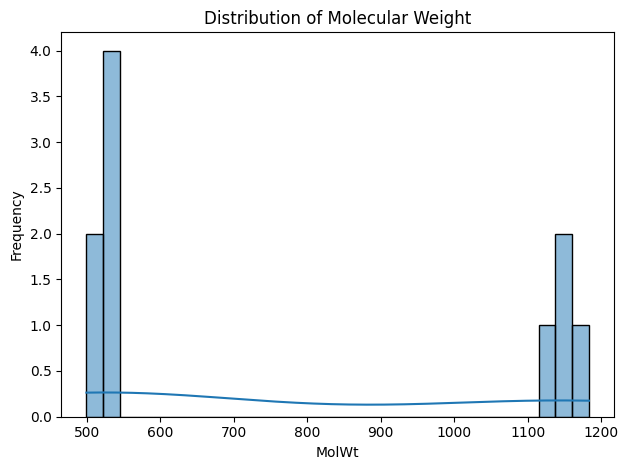

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(final_df['MolWt'], bins=30, kde=True)
plt.title("Distribution of Molecular Weight")
plt.xlabel("MolWt")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("../data/T7_molwt_distribution.png")

In [3]:
from rdkit.Chem import AllChem
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2, nBits=2048)
       for smi in data['canonical_smiles']]
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import numpy as np

fp_array = np.zeros((len(fps), 2048))
for i, fp in enumerate(fps):
    ConvertToNumpyArray(fp, fp_array[i])
pd.DataFrame(fp_array).to_csv("../data/T7_morgan_fp.csv", index=False)

[13:43:33] DEPRECATION WARNING: please use MorganGenerator
[13:43:33] DEPRECATION WARNING: please use MorganGenerator
[13:43:33] DEPRECATION WARNING: please use MorganGenerator
[13:43:33] DEPRECATION WARNING: please use MorganGenerator
[13:43:33] DEPRECATION WARNING: please use MorganGenerator
[13:43:33] DEPRECATION WARNING: please use MorganGenerator
[13:43:33] DEPRECATION WARNING: please use MorganGenerator
[13:43:33] DEPRECATION WARNING: please use MorganGenerator
[13:43:33] DEPRECATION WARNING: please use MorganGenerator
[13:43:33] DEPRECATION WARNING: please use MorganGenerator


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import joblib

X = final_df[['MolWt', 'LogP', 'TPSA']]
y = final_df['ic50_nm']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = RandomForestRegressor()
model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")
y_pred = model.predict(X_test)
print("R2 score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred)**0.5)  # Compatible format

joblib.dump(model, "../data/T7_rf_model.pkl")

R2 score: 0.8676974459470348
RMSE: 1710.5492411973678


['../data/T7_rf_model.pkl']

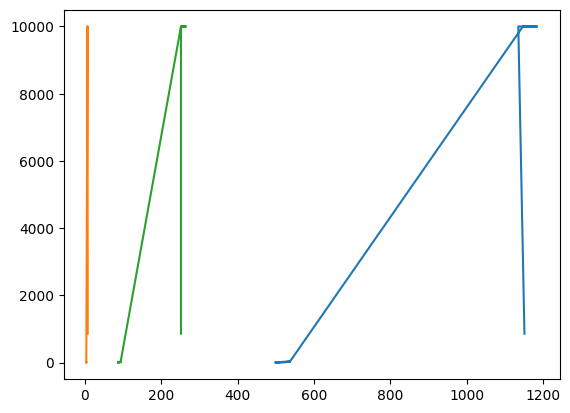

In [10]:
import matplotlib.pyplot as plt
plt.plot(X, y)